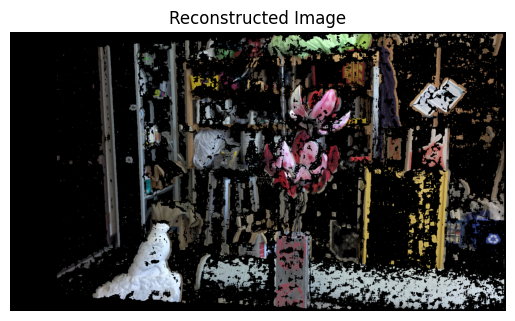

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# קריאה של התמונות בצבע
img_left = cv2.imread('im0.png')
img_right = cv2.imread('im1.png', cv2.IMREAD_GRAYSCALE)

# פרמטרים מתוך קובץ הכיול (calib.txt)
cam0 = np.array([[1733.74, 0, 792.27], 
                 [0, 1733.74, 541.89], 
                 [0, 0, 1]])  # מטריצת כיול של מצלמה שמאלית

doffs = 0         # הפרש מרכזי תמונות
baseline = 536.62  # בסיס בין המצלמות
width = 1920      # רוחב התמונה
height = 1080     # גובה התמונה
ndisp = 176       # מספר ה-disparities המקסימלי

# יצירת אובייקט StereoBM לחישוב disparity
stereo = cv2.StereoBM_create(numDisparities=ndisp, blockSize=15)

# חישוב disparity map
disparity = stereo.compute(cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY), img_right).astype(np.float32) / 16.0

# מטריצה Q המבוססת על הכיול, לצורך שחזור תלת ממדי
focal_length = cam0[0, 0]  # האורך המוקדי
cx = cam0[0, 2]  # מרכז התמונה בציר x
cy = cam0[1, 2]  # מרכז התמונה בציר y

Q = np.float32([[1, 0, 0, -cx],
                [0, -1, 0, cy],
                [0, 0, 0, focal_length],
                [0, 0, 1 / baseline, (doffs - cx) / baseline]])

# שחזור תלת ממדי
points_3d = cv2.reprojectImageTo3D(disparity, Q)

# יצירת מסכה שתשמור רק על נקודות בעלות disparity חיובי
mask = disparity > disparity.min()

# יצירת התמונה המפוקסת
reconstructed_image = np.zeros((height, width, 3), dtype=np.uint8)

# שליפת הצבעים מהתמונה השמאלית
img_left_rgb = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
for y in range(height):
    for x in range(width):
        if mask[y, x]:
            # קבלת הצבעים מתוך התמונה השמאלית
            reconstructed_image[y, x] = img_left_rgb[y, x]

# הצגת התמונה המשוחזרת
plt.imshow(reconstructed_image)
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()
